# PPO Clip Visualization

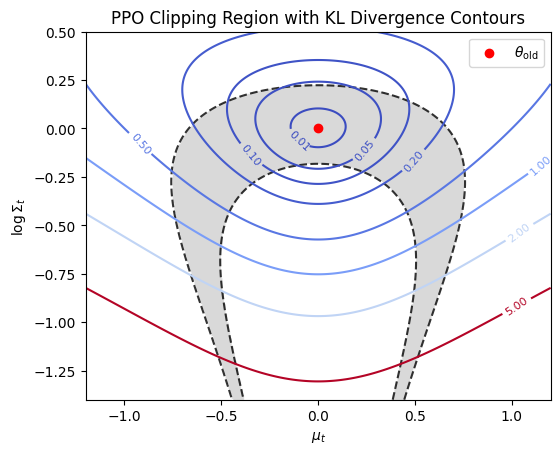

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters (example values similar to PPO paper)
mu_old = 0.0           # old policy mean
log_std_old = 0.0      # old policy log std (σ_old = 1)
sigma_old = np.exp(log_std_old)

a_t = 0.0              # action taken
eps = 0.2              # PPO clip epsilon

# Grid for μ_t and log σ_t
mu_range = np.linspace(-1.2, 1.2, 300)
log_std_range = np.linspace(-1.4, 0.5, 300)
MU, LOG_STD = np.meshgrid(mu_range, log_std_range)
SIGMA = np.exp(LOG_STD)

# Compute log r_t
log_r = (log_std_old - LOG_STD) + \
        ((a_t - mu_old)**2) / (2 * sigma_old**2) - \
        ((a_t - MU)**2) / (2 * SIGMA**2)

# Clip bounds in log space
lower_bound = np.log(1 - eps)
upper_bound = np.log(1 + eps)

# Region mask
mask = (log_r >= lower_bound) & (log_r <= upper_bound)

# Compute KL divergence D_KL( pi_old || pi_new ) for Gaussian policies
KL = np.log(SIGMA / sigma_old) + \
     (sigma_old**2 + (MU - mu_old)**2) / (2 * SIGMA**2) - 0.5

# Plot with KL contours
plt.figure(figsize=(6,6))
plt.contour(MU, LOG_STD, log_r, levels=[lower_bound, upper_bound],
            colors='k', linestyles='--', linewidths=1.5, alpha=0.8)
plt.imshow(1-mask, extent=[mu_range.min(), mu_range.max(), log_std_range.min(), log_std_range.max()],
           origin='lower', alpha=0.15, cmap='gray')

# KL divergence contours
kl_levels = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0]
contours = plt.contour(MU, LOG_STD, KL, levels=kl_levels, cmap='coolwarm')
plt.clabel(contours, inline=True, fontsize=8, fmt="%.2f")

# Mark theta_old
plt.scatter(mu_old, log_std_old, color='red', label=r'$\theta_{\mathrm{old}}$')
plt.xlabel(r'$\mu_t$')
plt.ylabel(r'$\log \Sigma_t$')
plt.legend()
plt.title("PPO Clipping Region with KL Divergence Contours")
plt.show()


# Misc

In [2]:
import jax
import jax.numpy as jnp
from cartpole import CartPoleEnv, CartPoleParams
from agent import ActorCritic

In [9]:
env = CartPoleEnv()
env_params = CartPoleParams(num_agents=3)
key = jax.random.PRNGKey(9)
keys = jax.random.split(key, env_params.num_agents)
obs, state = env.reset(keys, env_params)

network = ActorCritic(action_dim=env.action_space(env_params)[0].shape[0])
rng = jax.random.PRNGKey(0)
init_x = jnp.zeros(env.observation_space(env_params)[0].shape[0])
network_params = network.init(rng, init_x)

In [10]:
a = network.apply(network_params, init_x)

In [13]:
def animate():
    a = network.apply(network_params, init_x)
    print(a)

animate()

(<agent.MultivariateNormalDiag object at 0x77c1161a3050>, Array(0., dtype=float32))


In [39]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
class Linear(nn.Module):
    @nn.compact
    def __call__(self, x):
        # Actor network
        w = self.param("weight", nn.initializers.zeros, x.shape)
        return x*w
    
# Example input and target
x = jnp.ones((1, 3))
target = jnp.ones((1, 3)) * 2.0


# Initialize parameters
model = Linear()
rng = jax.random.PRNGKey(0)
params = model.init(rng, x)

# Loss function: mean squared error between output and target
def loss_fn(params):
    out = model.apply(params, x)
    return jnp.mean((out - target) ** 2)

# Optimizer
optimizer = optax.adam(learning_rate=0.05)
opt_state = optimizer.init(params)

# Training loop
for step in range(200):
    grads = jax.grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    print(f"Step {step}: log_std = {params}")

Step 0: log_std = {'params': {'weight': Array([[0.04999967, 0.04999967, 0.04999967]], dtype=float32)}}
Step 1: log_std = {'params': {'weight': Array([[0.09996217, 0.09996217, 0.09996217]], dtype=float32)}}
Step 2: log_std = {'params': {'weight': Array([[0.14986207, 0.14986207, 0.14986207]], dtype=float32)}}
Step 3: log_std = {'params': {'weight': Array([[0.1996719, 0.1996719, 0.1996719]], dtype=float32)}}
Step 4: log_std = {'params': {'weight': Array([[0.2493643, 0.2493643, 0.2493643]], dtype=float32)}}
Step 5: log_std = {'params': {'weight': Array([[0.29891092, 0.29891092, 0.29891092]], dtype=float32)}}
Step 6: log_std = {'params': {'weight': Array([[0.3482821, 0.3482821, 0.3482821]], dtype=float32)}}
Step 7: log_std = {'params': {'weight': Array([[0.397448, 0.397448, 0.397448]], dtype=float32)}}
Step 8: log_std = {'params': {'weight': Array([[0.44637787, 0.44637787, 0.44637787]], dtype=float32)}}
Step 9: log_std = {'params': {'weight': Array([[0.49504054, 0.49504054, 0.49504054]], dt

In [45]:
(3,)+x.shape

(3, 1, 3)